# Clustering

The following notebook subject the data to cluster analysis to see if any meaningful insights can be derived.

## Contents

- [tSNE visualization](#tsne)
- [kMeans](#km)
- [DBSCAN](#dbs)
- [Hierarchical](#hier)
- [Summary](#summary)

In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import calendar
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import pyplot

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from Utils.PipelineUtils import *
from Utils.DataUtils import *
from Utils.VizUtils import *

In [3]:
train_data = pd.read_csv("./train_data_scaled_encoded.csv")
val_data = pd.read_csv("./val_data_preprocessed.csv")
display(
    train_data.shape,
    train_data.head(),
    val_data.shape,
    val_data.head())

(8543, 38)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue,BounceRates_x_PageValues,Month_Jan,Month_Feb,Month_Mar,Month_Apr,Month_May,Month_June,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec,VisitorType_0,VisitorType_1,Weekend_0,quarter_0,quarter_1,quarter_2,OperatingSystems_agg_0,OperatingSystems_agg_1,OperatingSystems_agg_2,TrafficType_agg_0,TrafficType_agg_1,TrafficType_agg_2,TrafficType_agg_3,TrafficType_agg_4,TrafficType_agg_5,TrafficType_agg_6,TrafficType_agg_7,TrafficType_agg_8
0,-0.700298,-0.405807,-0.228228,-0.447944,-0.315005,-0.312378,False,-0.168900,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.995396,-0.405807,-0.342283,0.093365,-0.315005,-0.312378,False,-0.168900,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,5.290134,2.018536,11.063226,-0.350027,0.130124,-0.312378,True,0.100857,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.700298,-0.405807,-0.616015,2.678117,-0.315005,-0.312378,False,-0.168900,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.400776,-0.405807,-0.410716,-0.447944,5.847602,-0.312378,True,-0.168900,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(1831, 38)

,Administrative,Informational,ProductRelated,BounceRates,PageValues,SpecialDay,Revenue,BounceRates_x_PageValues,Month_Jan,Month_Feb,Month_Mar,Month_Apr,Month_May,Month_June,Month_Jul,Month_Aug,Month_Sep,Month_Oct,Month_Nov,Month_Dec,VisitorType_0,VisitorType_1,Weekend_0,quarter_0,quarter_1,quarter_2,OperatingSystems_agg_0,OperatingSystems_agg_1,OperatingSystems_agg_2,TrafficType_agg_0,TrafficType_agg_1,TrafficType_agg_2,TrafficType_agg_3,TrafficType_agg_4,TrafficType_agg_5,TrafficType_agg_6,TrafficType_agg_7,TrafficType_agg_8
0,-0.400776,-0.405807,-0.593204,-0.447944,-0.315005,-0.312378,False,-0.168900,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.797310,1.210422,5.907936,-0.420562,0.162429,-0.312378,False,-0.087989,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.101255,-0.405807,0.478914,-0.366748,0.116945,-0.312378,True,0.048168,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.198267,-0.405807,-0.616015,-0.447944,2.112598,-0.312378,True,-0.168900,0,0,0,0,0,0,0,0,1,0,0,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.101255,-0.405807,1.687898,-0.433901,-0.315005,-0.312378,False,-0.168900,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
# Quick helper variable
rev_palette = {1:'cornflowerblue', 0:'mistyrose'}

In [5]:
# Quick mapping
train_data["Revenue"] = train_data["Revenue"].astype(int)
val_data["Revenue"] = val_data["Revenue"].astype(int)

------------

# tSNE visualization<a id='tsne'></a>

tSNE projects high dimensional data into lower dimensions for visualization.

In [9]:
from sklearn.manifold import TSNE
model=TSNE(learning_rate=100)
Tsne_transformed=model.fit_transform(train_data[xcol].values)

In [10]:
xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]

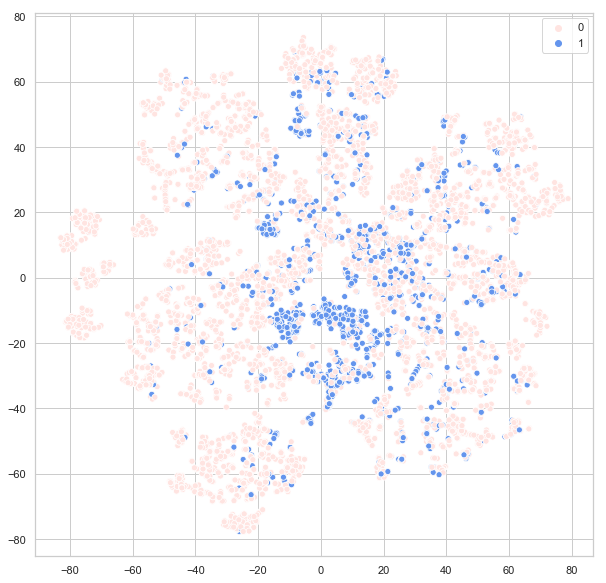

In [22]:
f, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(xs,ys, hue=train_data[ycol].values.ravel(), ax=ax, palette=rev_palette)


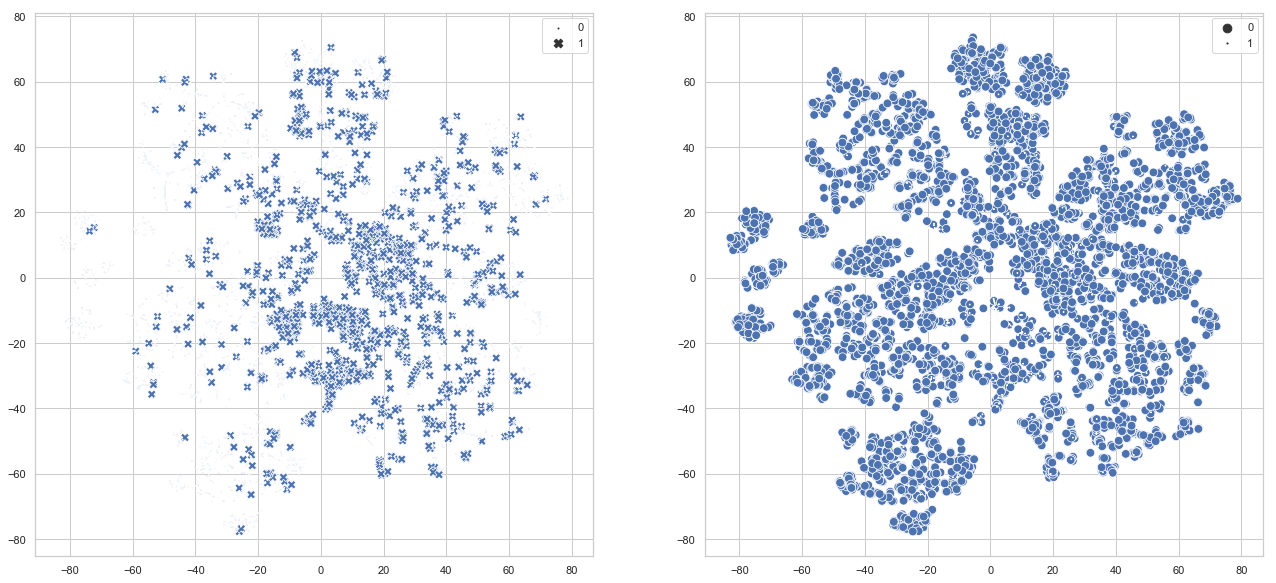

In [11]:
f, ax = plt.subplots(1,2,figsize=(22,10))
sns.scatterplot(xs,ys, style=train_data[ycol].values.ravel(), ax=ax[0], size=train_data[ycol].values.ravel(), sizes=(75,1))
sns.scatterplot(xs,ys, style=train_data[ycol].values.ravel(), ax=ax[1], size=train_data[ycol].values.ravel(), sizes=(1,75))


The data points are quite dispersed throughout, the ones that generate revenue are predominantly clustered around the center.

-------

# KMeans<a id='km'></a>

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


def kmeans_analysis(array, start=1, end=10, step=1, figsize=(12,6)):
    inertia, x_axis = list([]), list([])    
    silhouette_arr, silhouette_xaxis = list([]), list([])
    
    for n_clusters in range(start,end+1,step):
        kmeans = KMeans(n_clusters, random_state=0).fit(array)   
        inertia.append(kmeans.inertia_)
        x_axis.append(n_clusters)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(array, cluster_labels)
        silhouette_arr.append(silhouette_avg)
        silhouette_xaxis.append(n_clusters)

    fig, ax = plt.subplots(1, 2, figsize=figsize)

    g = sns.lineplot(x=x_axis, y=inertia, ax=ax[0])
    g.set(title="Elbow method", ylabel="intertia", xlabel="num_clusters")
    g = sns.lineplot(x=silhouette_xaxis, y=silhouette_arr, ax=ax[1])
    g.set(title="Silhouette score", ylabel="intertia", xlabel="num_clusters")

    return ax

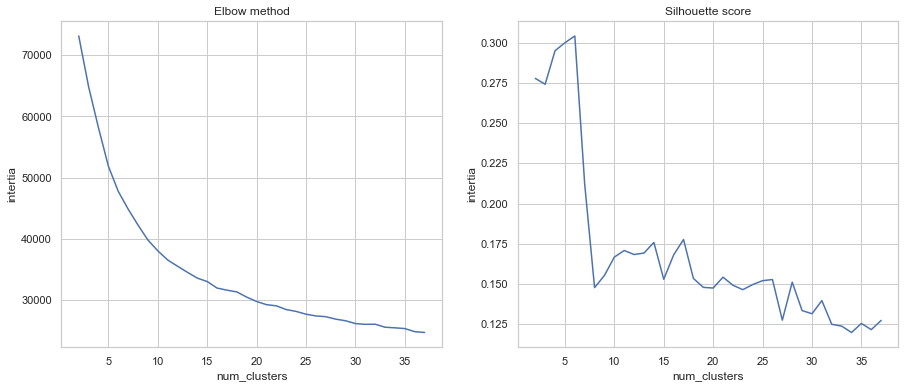

In [7]:
ycol = ["Revenue"]
xcol = [c for c in train_data.columns if c not in ycol]
inertia = kmeans_analysis(train_data[xcol], start=2, step=1, end=len(xcol), figsize=(15,6))

6 Clusters give a decent silhouette score. 

Let's visualize this using tSNE

In [8]:
kmeans = KMeans(6, random_state=0).fit(train_data[xcol])   
labels = kmeans.labels_

How do the KMeans clusters perform for the tSNE section?

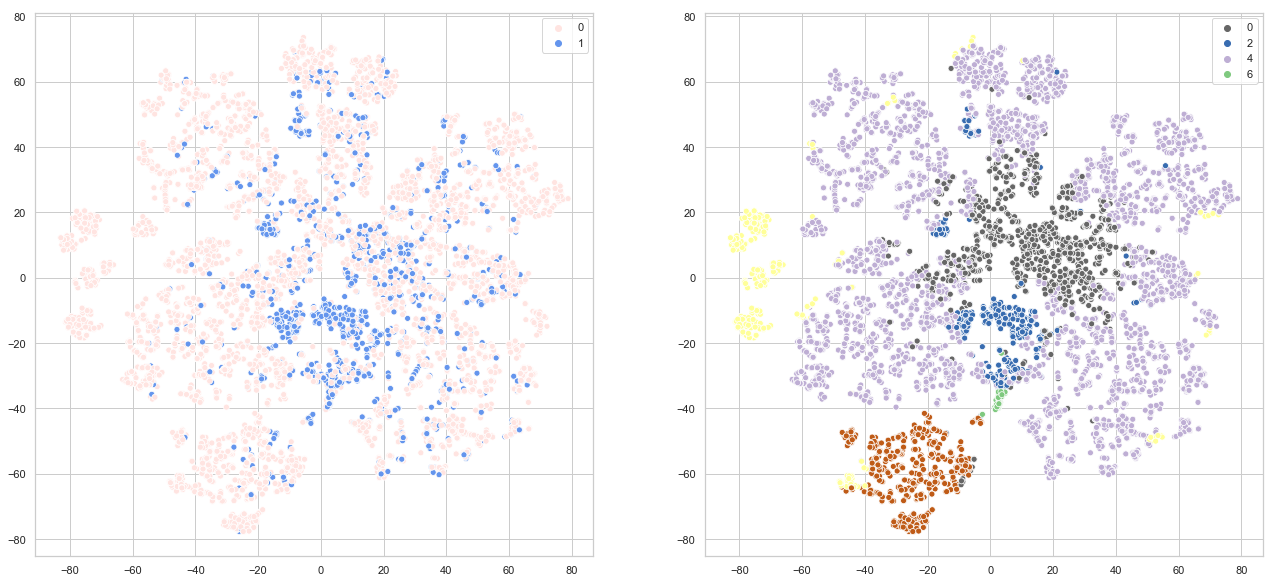

In [12]:
f, ax = plt.subplots(1,2,figsize=(22,10))
sns.scatterplot(xs,ys, hue=train_data[ycol].values.ravel(), ax=ax[0], palette=rev_palette)
sns.scatterplot(xs,ys, hue=labels, ax=ax[1], palette='Accent_r')
plt.show()

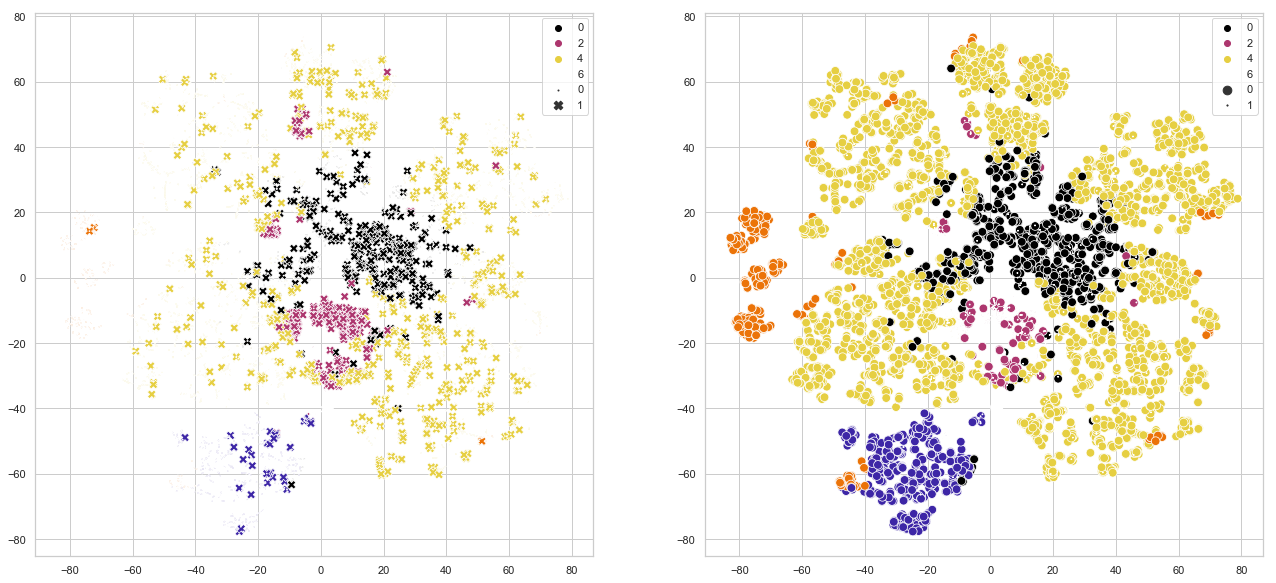

In [13]:
f, ax = plt.subplots(1,2,figsize=(22,10))
sns.scatterplot(xs,ys, style=train_data[ycol].values.ravel(), hue=labels, ax=ax[0], palette='CMRmap', size=train_data[ycol].values.ravel(), sizes=(75,1))
sns.scatterplot(xs,ys, style=train_data[ycol].values.ravel(), hue=labels, ax=ax[1], palette='CMRmap', size=train_data[ycol].values.ravel(), sizes=(1,75))

------------

# DBSCAN<a id='dbs'></a>

In [14]:
from sklearn.cluster import DBSCAN

In [15]:
def cluster_dbscan(array, eps, min_samples):
    """
    Clusters using the DBSCAN algorithm
    params :
    @array : numpy array of features 
    @eps : radius of the neighbourhood to search 
    @min_samples : minimum number of samples to consider a group
                    a viable cluster
    Returns : 
        model, labels, core_samples
    """
    dbsc = DBSCAN(eps, min_samples).fit(array)
    #Get the cluster labels
    labels = dbsc.labels_
    #Identify the core and border points
    core_samples = np.zeros_like(labels, dtype = bool)
    core_samples[dbsc.core_sample_indices_] = True
    return dbsc, labels, core_samples

In [16]:
dbscan_model, dbscan_labels, core_samples = cluster_dbscan(train_data[xcol], eps=1.7, min_samples=50)

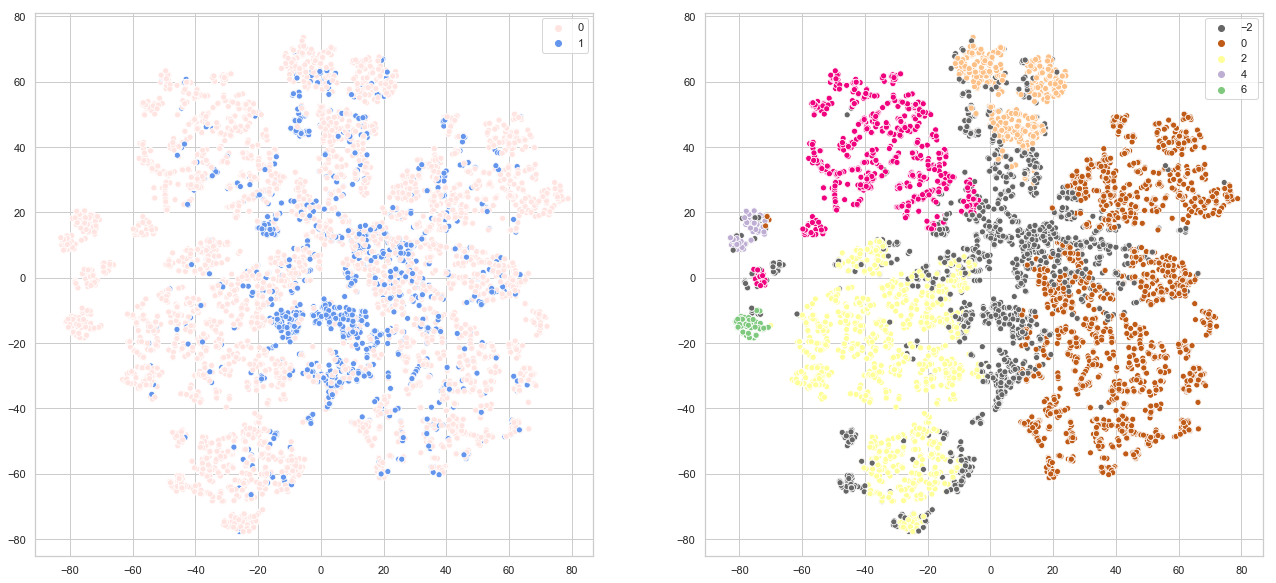

In [17]:
f, ax = plt.subplots(1,2,figsize=(22,10))
sns.scatterplot(xs,ys, hue=train_data[ycol].values.ravel(), ax=ax[0], palette=rev_palette)
sns.scatterplot(xs,ys, hue=dbscan_labels, ax=ax[1], palette='Accent_r')
plt.show()

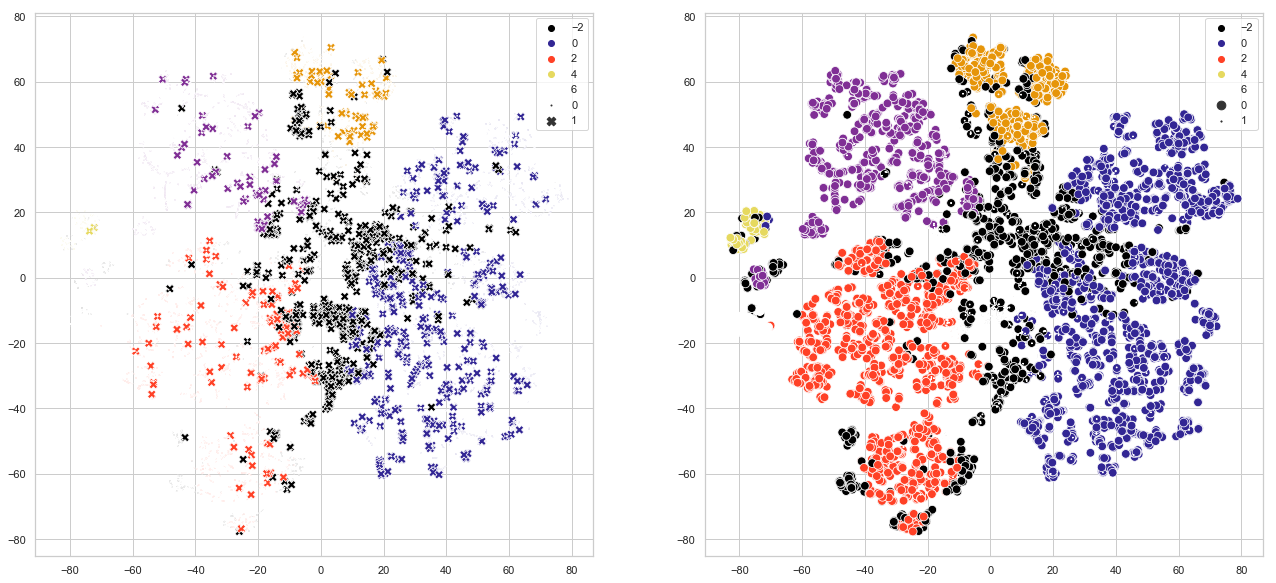

In [18]:
f, ax = plt.subplots(1,2,figsize=(22,10))
sns.scatterplot(xs,ys, style=train_data[ycol].values.ravel(), hue=dbscan_labels, ax=ax[0], palette='CMRmap', size=train_data[ycol].values.ravel(), sizes=(75,1))
sns.scatterplot(xs,ys, style=train_data[ycol].values.ravel(), hue=dbscan_labels, ax=ax[1], palette='CMRmap', size=train_data[ycol].values.ravel(), sizes=(1,75))

-----------

# Hierarchical clustering<a id='hier'></a>

We can use hierarchical clustering to see if features are grouping together meaningfully.

In [19]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import normalize

def viz_hierarchical_cluster(array):
    normalized_movements = normalize(array)

    # Calculate the linkage: mergings
    mergings = linkage(normalized_movements, method='complete', )
    return mergings

mergings = viz_hierarchical_cluster(train_data[xcol])

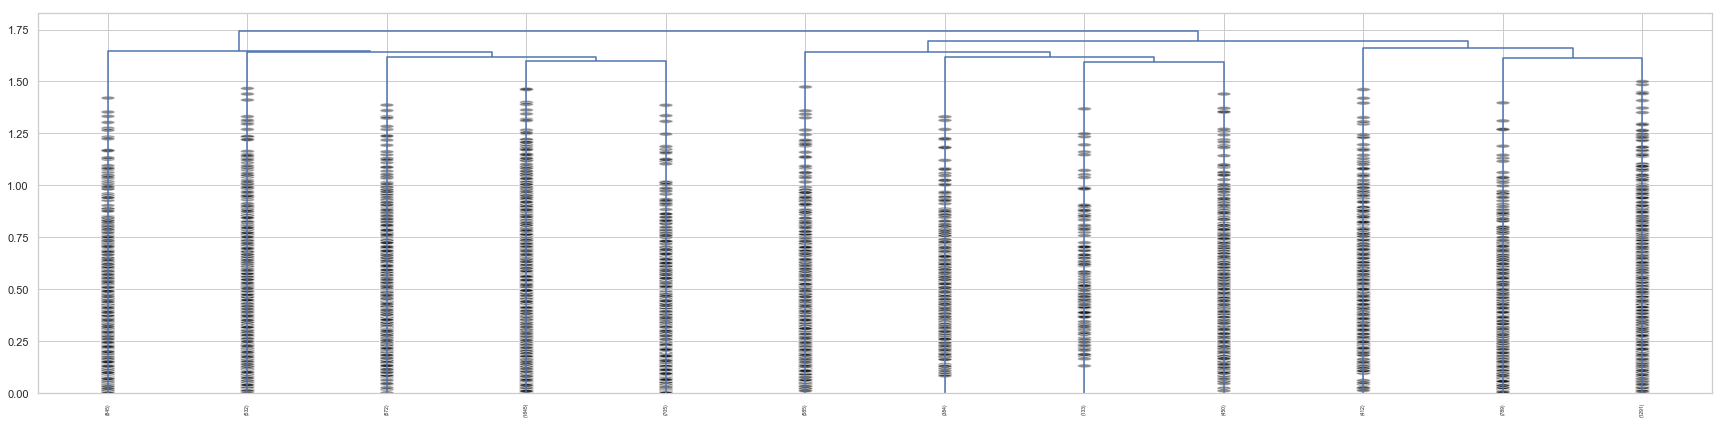

In [23]:
# Plot the dendrogram
plt.figure(figsize=(30,7))

dendrogram(
    mergings,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    labels=train_data[xcol].index,
    leaf_rotation=90.,
    leaf_font_size=5,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

Hierachical clustering doesn't really give any meaningful clusters here.

-------------------

# Summary:<a id='summary'></a>

- KMeans clusters the center well, but fails in precision. 
- DBSCAN considers majority of the center as outliers, and some peripheral points as well
- Hierarchical gives no meaningful insights

Clustering does not seem to give any immediate separability to the data. 

We can proceed to predictive modeling for classification.